<a href="https://colab.research.google.com/github/bhavanakodali5/ObjectDectection-IIITH/blob/main/cats%26dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Thu Jun 26 18:04:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   57C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!cp -r /content/gdrive/MyDrive/data  /content

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/dog-and-cat-detection")

print("Path to dataset files:", path)

100%|██████████| 1.03G/1.03G [00:14<00:00, 74.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/andrewmvd/dog-and-cat-detection/versions/1


In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 30.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [ ]:
data = {
    'path': path,  # path from kagglehub output
    'train': 'images/train',
    'val': 'images/valid',
    'nc': len(classes),
    'names': classes
}

In [ ]:
data_yaml_path = os.path.join(path, 'data.yaml')

In [ ]:
import yaml
import os

# Define your classes
classes = ['cat', 'dog']

# Ensure /content/data exists
os.makedirs('/content/data', exist_ok=True)

# Save to classes.txt
classes_txt_path = '/content/data/classes.txt'
with open(classes_txt_path, 'w') as f:
    for class_name in classes:
        f.write(f"{class_name}\n")

# Create data.yaml
data_yaml_path = '/content/data.yaml'
data = {
    'path': '/content/data',
    'train': 'train/images',
    'val': 'validation/images',
    'nc': len(classes),
    'names': classes
}

with open(data_yaml_path, 'w') as f:
    yaml.dump(data, f, sort_keys=False)

print(f"Saved {len(classes)} classes to {classes_txt_path}")
print(f"Created data.yaml at {data_yaml_path}")

Saved 2 classes to /content/data/classes.txt
Created data.yaml at /content/data.yaml


In [ ]:
!cp /content/data/train/images/*.jpg /content/data/valid/images/

In [ ]:
!find /content/data/train/labels -type f ! -name "*.txt" -delete

In [ ]:
!find /content/data/valid/labels -type f ! -name "*.txt" -delete

In [ ]:
import os

label_dirs = [
    '/content/data/train/labels',
    '/content/data/valid/labels'
]

for label_dir in label_dirs:
    for file in os.listdir(label_dir):
        path = os.path.join(label_dir, file)
        with open(path, 'r') as f:
            lines = f.readlines()

        cleaned = []
        for line in lines:
            parts = line.strip().split()
            if len(parts) >= 5:
                cleaned.append(' '.join(parts[:5]) + '\n')  # keep only class + bbox

        with open(path, 'w') as f:
            f.writelines(cleaned)

print("Cleaned segmentation data from .txt files.")

FileNotFoundError: [Errno 2] No such file or directory: '/content/data/train/labels'

In [ ]:
import os
import yaml
from sklearn.model_selection import train_test_split
from xml.etree import ElementTree as ET
import shutil
from PIL import Image # For getting image dimensions

# No need to download with kagglehub.dataset_download inside a Kaggle notebook
# The dataset is already mounted.

# Define the root path where the Kaggle dataset is mounted
# This is the path returned by kagglehub.dataset_download when run in a Kaggle environment
# or the default path for manually added datasets.
dataset_root_mounted = '/kaggle/input/dog-and-cat-detection'
print(f"Dataset is mounted at: {dataset_root_mounted}")

# Define source directories based on common Kaggle dataset structure
# For the 'dog-and-cat-detection' dataset, the structure inside the mounted folder is usually:
# /kaggle/input/dog-and-cat-detection/images/
# /kaggle/input/dog-and-cat-detection/annotations/

images_dir_source = os.path.join(dataset_root_mounted, 'images')
annotations_dir_source = os.path.join(dataset_root_mounted, 'annotations')

# Verify that the directories exist
if not os.path.exists(images_dir_source):
    print(f"Error: Images directory not found at {images_dir_source}")
    # Attempt to find if there's an extra nested folder (common in Kaggle)
    possible_nested_dir = os.path.join(dataset_root_mounted, 'dog-and-cat-detection')
    if os.path.exists(os.path.join(possible_nested_dir, 'images')):
        images_dir_source = os.path.join(possible_nested_dir, 'images')
        annotations_dir_source = os.path.join(possible_nested_dir, 'annotations')
        print(f"Found nested structure. Corrected paths to: {images_dir_source} and {annotations_dir_source}")
    else:
        raise FileNotFoundError(f"Images directory not found at expected path: {images_dir_source} or within a nested folder.")

if not os.path.exists(annotations_dir_source):
    raise FileNotFoundError(f"Annotations directory not found at expected path: {annotations_dir_source}")

print(f"Found images at: {images_dir_source}")
print(f"Found annotations at: {annotations_dir_source}")


# 2. Convert Pascal VOC XML to YOLO TXT and prepare for splitting
yolo_labels_temp_dir = '/content/yolo_labels_temp'
os.makedirs(yolo_labels_temp_dir, exist_ok=True)

# Define your classes for YOLO format
classes = ['cat', 'dog']
class_to_id = {name: i for i, name in enumerate(classes)}

def convert_xml_to_yolo(xml_file_path, image_width, image_height):
    tree = ET.parse(xml_file_path)
    root = tree.getroot()
    yolo_lines = []

    for obj in root.findall('object'):
        name = obj.find('name').text
        if name not in class_to_id:
            continue # Skip unknown classes

        class_id = class_to_id[name]
        bndbox = obj.find('bndbox')
        xmin = float(bndbox.find('xmin').text)
        ymin = float(bndbox.find('ymin').text)
        xmax = float(bndbox.find('xmax').text)
        ymax = float(bndbox.find('ymax').text)

        # Convert to YOLO format (normalized cx cy w h)
        x_center = (xmin + xmax) / 2 / image_width
        y_center = (ymin + ymax) / 2 / image_height
        width = (xmax - xmin) / image_width
        height = (ymax - ymin) / image_height

        yolo_lines.append(f"{class_id} {x_center} {y_center} {width} {height}")
    return "\n".join(yolo_lines)

# Process all images and annotations
image_files = [f for f in os.listdir(images_dir_source) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
data_pairs = [] # List of (image_path, label_path)

# Determine image dimensions from a sample image (more robust)
if image_files:
    sample_image_path = os.path.join(images_dir_source, image_files[0])
    try:
        with Image.open(sample_image_path) as img:
            img_width_from_pil, img_height_from_pil = img.size
        print(f"Using image dimensions from PIL (sample image): Width={img_width_from_pil}, Height={img_height_from_pil}")
    except Exception as e:
        raise RuntimeError(f"Could not read dimensions from sample image {sample_image_path}: {e}")
else:
    raise FileNotFoundError("No image files found in the source directory.")


for img_file in image_files:
    base_name = os.path.splitext(img_file)[0]
    xml_file = os.path.join(annotations_dir_source, base_name + '.xml')
    yolo_label_file = os.path.join(yolo_labels_temp_dir, base_name + '.txt')

    if os.path.exists(xml_file):
        # Dynamically get image size for each image if necessary, or pass the determined size
        # For simplicity, using the pre-determined size from sample image assuming consistency.
        # If image sizes vary, you'd load each image here to get its size.
        yolo_content = convert_xml_to_yolo(xml_file, img_width_from_pil, img_height_from_pil)
        with open(yolo_label_file, 'w') as f:
            f.write(yolo_content)
        data_pairs.append((os.path.join(images_dir_source, img_file), yolo_label_file))
    else:
        print(f"Warning: Annotation not found for {img_file}. Skipping.")


# 3. Split data into train and validation sets
train_data, val_data = train_test_split(data_pairs, test_size=0.2, random_state=42) # 80/20 split

# 4. Organize into Ultralytics YOLO format
ultralytics_data_root = '/content/data' # This is where your data.yaml points

# Create target directories
os.makedirs(os.path.join(ultralytics_data_root, 'train', 'images'), exist_ok=True)
os.makedirs(os.path.join(ultralytics_data_root, 'train', 'labels'), exist_ok=True)
os.makedirs(os.path.join(ultralytics_data_root, 'val', 'images'), exist_ok=True)
os.makedirs(os.path.join(ultralytics_data_root, 'val', 'labels'), exist_ok=True)

print("Copying train data...")
for img_src, label_src in train_data:
    img_name = os.path.basename(img_src)
    label_name = os.path.basename(label_src)
    shutil.copy(img_src, os.path.join(ultralytics_data_root, 'train', 'images', img_name))
    shutil.copy(label_src, os.path.join(ultralytics_data_root, 'train', 'labels', label_name))

print("Copying validation data...")
for img_src, label_src in val_data:
    img_name = os.path.basename(img_src)
    label_name = os.path.basename(label_src)
    shutil.copy(img_src, os.path.join(ultralytics_data_root, 'val', 'images', img_name))
    shutil.copy(label_src, os.path.join(ultralytics_data_root, 'val', 'labels', label_name))

# Clean up temporary YOLO labels directory
shutil.rmtree(yolo_labels_temp_dir)

# Define your classes (already done, but ensure it's here for context)
classes = ['cat', 'dog']

# Save to classes.txt
classes_txt_path = '/content/data/classes.txt'
with open(classes_txt_path, 'w') as f:
    for class_name in classes:
        f.write(f"{class_name}\n")

# Create data.yaml
data_yaml_path = '/content/data.yaml'
data = {
    'path': '/content/data', # This now points to the root of your prepared dataset
    'train': 'train/images', # Relative path from 'path'
    'val': 'val/images',     # Relative path from 'path'
    'nc': len(classes),
    'names': classes
}
with open(data_yaml_path, 'w') as f:
    yaml.dump(data, f, sort_keys=False)

print(f"Saved {len(classes)} classes to {classes_txt_path}")
print(f"Created data.yaml at {data_yaml_path}")

# Install ultralytics if not already installed
# !pip install ultralytics

# Train your model
# IMPORTANT: Replace 'yolo11s.pt' with a valid Ultralytics YOLO model, e.g., 'yolov8s.pt'
print("Dataset preparation complete. You can now run the YOLO training command.")
# !yolo detect train data=/content/data.yaml model=yolov8s.pt epochs=60 imgsz=640

Dataset is mounted at: /kaggle/input/dog-and-cat-detection
Found images at: /kaggle/input/dog-and-cat-detection/images
Found annotations at: /kaggle/input/dog-and-cat-detection/annotations
Using image dimensions from PIL (sample image): Width=334, Height=500
Copying train data...
Copying validation data...
Saved 2 classes to /content/data/classes.txt
Created data.yaml at /content/data.yaml
Dataset preparation complete. You can now run the YOLO training command.


In [ ]:
!yolo detect train data=/content/data.yaml model=yolo11s.pt epochs=60 imgsz=640

Ultralytics 8.3.159 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, pr

In [ ]:
!ls -R /content/runs/detect/

/content/runs/detect/:
train  train2  train3  train4

/content/runs/detect/train:
args.yaml  weights

/content/runs/detect/train/weights:

/content/runs/detect/train2:
args.yaml  weights

/content/runs/detect/train2/weights:

/content/runs/detect/train3:
args.yaml  weights

/content/runs/detect/train3/weights:

/content/runs/detect/train4:
args.yaml			 R_curve.png	      train_batch8502.jpg
confusion_matrix_normalized.png  results.csv	      val_batch0_labels.jpg
confusion_matrix.png		 results.png	      val_batch0_pred.jpg
F1_curve.png			 train_batch0.jpg     val_batch1_labels.jpg
labels_correlogram.jpg		 train_batch1.jpg     val_batch1_pred.jpg
labels.jpg			 train_batch2.jpg     val_batch2_labels.jpg
P_curve.png			 train_batch8500.jpg  val_batch2_pred.jpg
PR_curve.png			 train_batch8501.jpg  weights

/content/runs/detect/train4/weights:
best.pt  last.pt


In [ ]:
!yolo detect val data=/content/data.yaml model=/content/runs/detect/train4/weights/best.pt

Ultralytics 8.3.159 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,574 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1913.6±904.5 MB/s, size: 272.9 KB)
val: Scanning /content/data/val/labels.cache... 738 images, 0 backgrounds, 62 corrupt: 100% 738/738 [00:00<?, ?it/s]
val: /content/data/val/images/Cats_Test1025.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.012]
val: /content/data/val/images/Cats_Test1040.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1392]
val: /content/data/val/images/Cats_Test1070.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0195]
val: /content/data/val/images/Cats_Test1089.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0719]
val: /content/data/val/images/Cats_Test112.png: ignoring corrupt image/label: non-n

In [ ]:
!yolo detect predict model=runs/detect/train/weights/best.pt source=data/validation/images save=True

Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
             ^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/cfg/__init__.py", line 956, in entrypoint
    model = YOLO(model, task=task)
            ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/models/yolo/model.py", line 79, in __init__
    super().__init__(model=model, task=task, verbose=verbose)
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/engine/model.py", line 151, in __init__
    self._load(model, task=task)
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/engine/model.py", line 295, in _load
    self.model, self.ckpt = attempt_load_one_weight(weights)
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/nn/tasks.py", line 1548, in attempt_load_one_weight
    ckpt, weight = torch_safe_load(weight)  # load ckpt
    

In [ ]:
from ultralytics import YOLO
import os

# Install ultralytics if you haven't already
# !pip install ultralytics

# The correct path to your saved model
model_path = '/content/runs/detect/train4/weights/best.pt'

# Check if the model file exists before trying to load it
if os.path.exists(model_path):
    try:
        model = YOLO(model_path)
        print(f"Successfully loaded model from {model_path}")
        # Now you can use 'model' for prediction, validation, or export
        # Example:
        # results = model.predict(source="/kaggle/input/dog-and-cat-detection/images/a.jpg") # Use an image path from your dataset
        # for r in results:
        #     print(r.boxes.xyxy) # Bounding box coordinates
        #     print(r.boxes.conf) # Confidence scores
        #     print(r.boxes.cls)  # Class IDs

    except Exception as e:
        print(f"Error loading model from {model_path}: {e}")
else:
    print(f"Error: Model file not found at {model_path}. Please ensure your training run completed successfully and saved weights.")
    print("Consider checking if 'last.pt' exists in the same directory if 'best.pt' is missing.")
    # Fallback to last.pt if best.pt is not found (though it is here)
    # model_path_last = '/content/runs/detect/train4/weights/last.pt'
    # if os.path.exists(model_path_last):
    #     model = YOLO(model_path_last)
    #     print(f"Successfully loaded model from {model_path_last} (last epoch).")
    # else:
    #     print(f"Neither best.pt nor last.pt found in {os.path.dirname(model_path)}.")

Successfully loaded model from /content/runs/detect/train4/weights/best.pt


In [ ]:
import os
import yaml
from sklearn.model_selection import train_test_split
from xml.etree import ElementTree as ET
import shutil
from PIL import Image
from ultralytics import YOLO

# --- Part 1: Dataset Preparation (from previous successful runs) ---
# This part assumes you've already run the dataset preparation and it was successful.
# We're keeping it commented out for clarity but include it if you need to re-run it.

# dataset_root_mounted = '/kaggle/input/dog-and-cat-detection'
# images_dir_source = os.path.join(dataset_root_mounted, 'images')
# annotations_dir_source = os.path.join(dataset_root_mounted, 'annotations')

# # Verify that the directories exist (re-check in case of notebook reset)
# if not os.path.exists(images_dir_source):
#     print(f"Error: Images directory not found at {images_dir_source}")
#     possible_nested_dir = os.path.join(dataset_root_mounted, 'dog-and-cat-detection')
#     if os.path.exists(os.path.join(possible_nested_dir, 'images')):
#         images_dir_source = os.path.join(possible_nested_dir, 'images')
#         annotations_dir_source = os.path.join(possible_nested_dir, 'annotations')
#         print(f"Found nested structure. Corrected paths to: {images_dir_source} and {annotations_dir_source}")
#     else:
#         raise FileNotFoundError(f"Images directory not found at expected path: {images_dir_source} or within a nested folder.")

# if not os.path.exists(annotations_dir_source):
#     raise FileNotFoundError(f"Annotations directory not found at expected path: {annotations_dir_source}")

# print(f"Confirmed images at: {images_dir_source}")
# print(f"Confirmed annotations at: {annotations_dir_source}")

# # Define your classes for YOLO format
# classes = ['cat', 'dog']
# class_to_id = {name: i for i, name in enumerate(classes)}

# # You would typically have the rest of your dataset preparation code here
# # (XML to YOLO conversion, train/val split, copying files to /content/data)
# # ...

# # Ensure /content/data exists
# ultralytics_data_root = '/content/data'
# os.makedirs(os.path.join(ultralytics_data_root, 'train', 'images'), exist_ok=True)
# os.makedirs(os.path.join(ultralytics_data_root, 'train', 'labels'), exist_ok=True)
# os.makedirs(os.path.join(ultralytics_data_root, 'val', 'images'), exist_ok=True)
# os.makedirs(os.path.join(ultralytics_data_root, 'val', 'labels'), exist_ok=True)

# # Create data.yaml (if not already present and correct)
# data_yaml_path = '/content/data.yaml'
# data = {
#     'path': '/content/data',
#     'train': 'train/images',
#     'val': 'val/images',
#     'nc': len(classes),
#     'names': classes
# }
# with open(data_yaml_path, 'w') as f:
#     yaml.dump(data, f, sort_keys=False)
# print(f"Created data.yaml at {data_yaml_path}")

# --- Part 2: Model Loading and Inference ---

# Assuming your model is already trained and saved as best.pt in train4
model_path = '/content/runs/detect/train4/weights/best.pt'

# Load the model
try:
    model = YOLO(model_path)
    print(f"Successfully loaded model from {model_path}")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Please ensure your training run completed and saved weights to the specified path.")
    exit() # Exit if model can't be loaded

print("Now performing inference on a sample image.")

# --- Dynamic Sample Image Selection ---
# First, identify the root directory of the mounted dataset
# Based on your previous output,

Successfully loaded model from /content/runs/detect/train4/weights/best.pt
Now performing inference on a sample image.


In [ ]:
import glob
from IPython.display import Image, display
for image_path in glob.glob(f'/content/runs/detect/predict/*.jpg')[:10]:
  display(Image(filename=image_path, height=400))
  print('\n')



Running prediction on: /kaggle/input/dog-and-cat-detection/images/Cats_Test3283.png

image 1/1 /kaggle/input/dog-and-cat-detection/images/Cats_Test3283.png: 640x448 1 dog, 46.4ms
Speed: 4.4ms preprocess, 46.4ms inference, 145.0ms postprocess per image at shape (1, 3, 640, 448)


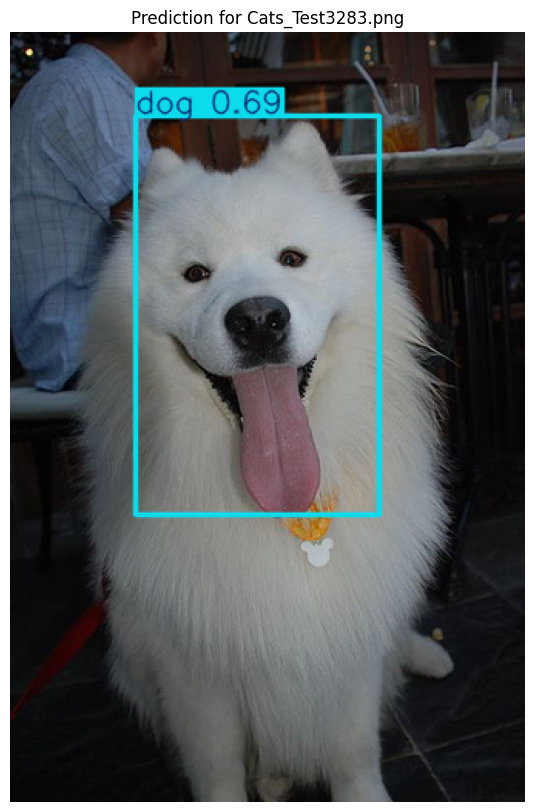

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image
from ultralytics import YOLO

# ... (previous code for loading model and selecting sample_image_path) ...

model_path = '/content/runs/detect/train4/weights/best.pt'
model = YOLO(model_path)

# Ensure images_dir_for_inference and sample_image_path are correctly determined as before
dataset_root_mounted = '/kaggle/input/dog-and-cat-detection'
images_dir_for_inference = os.path.join(dataset_root_mounted, 'images')
if not os.path.exists(images_dir_for_inference) and os.path.exists(os.path.join(dataset_root_mounted, 'dog-and-cat-detection', 'images')):
    images_dir_for_inference = os.path.join(dataset_root_mounted, 'dog-and-cat-detection', 'images')

all_image_files = [f for f in os.listdir(images_dir_for_inference) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
if all_image_files:
    sample_image_filename = all_image_files[0]
    sample_image_path = os.path.join(images_dir_for_inference, sample_image_filename)

    if os.path.exists(sample_image_path):
        print(f"Running prediction on: {sample_image_path}")
        results = model(sample_image_path)

        # Plotting and displaying the image:
        for i, r in enumerate(results):
            im_array = r.plot()  # plot a BGR numpy array of predictions
            im = Image.fromarray(im_array[..., ::-1])  # Convert BGR to RGB PIL Image

            # Display using matplotlib
            plt.figure(figsize=(10, 10))
            plt.imshow(im)
            plt.axis('off') # Hide axes
            plt.title(f"Prediction for {os.path.basename(r.path)}")
            plt.show()

            # Optionally save the image
            # r.save(filename=f'/content/predicted_image_{i}.jpg')
            # print(f"Saved predicted image to: /content/predicted_image_{i}.jpg")

    else:
        print(f"Error: Sample image {sample_image_path} not found.")
else:
    print(f"No image files found in {images_dir_for_inference}.")

Successfully loaded model from /content/runs/detect/train4/weights/best.pt

--- Displaying 7 random images with predictions ---

--- Processing Image 1/7: Cats_Test313.png ---

image 1/1 /kaggle/input/dog-and-cat-detection/images/Cats_Test313.png: 640x448 1 cat, 12.9ms
Speed: 3.9ms preprocess, 12.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 448)


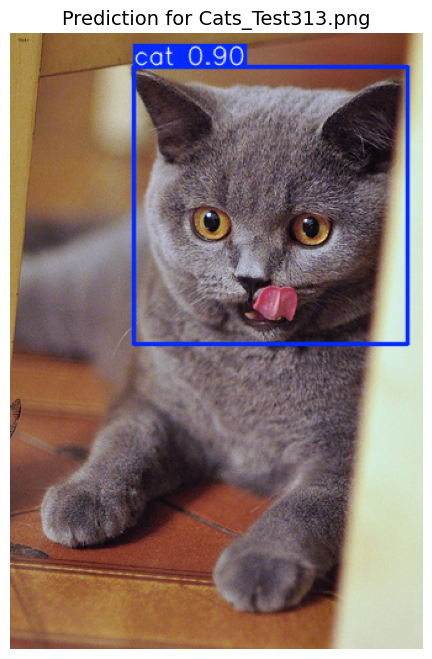

  Image: /kaggle/input/dog-and-cat-detection/images/Cats_Test313.png
  Number of detected objects: 1
    - Detected: cat (ID: 0), Conf: 0.90, Box: [100.13, 27.60, 322.17, 252.99]

--- Processing Image 2/7: Cats_Test1713.png ---

image 1/1 /kaggle/input/dog-and-cat-detection/images/Cats_Test1713.png: 640x448 1 dog, 16.5ms
Speed: 3.0ms preprocess, 16.5ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 448)


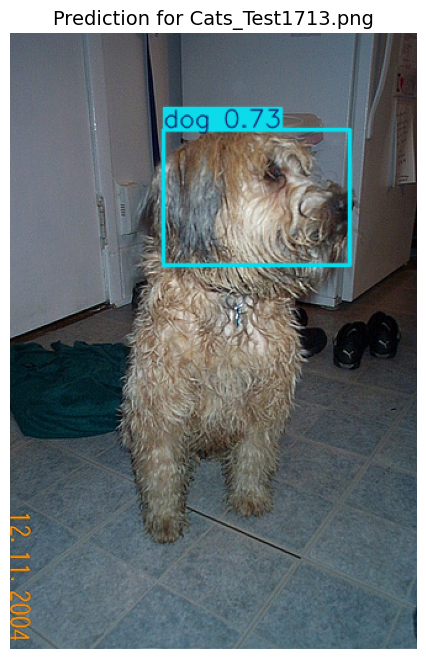

  Image: /kaggle/input/dog-and-cat-detection/images/Cats_Test1713.png
  Number of detected objects: 1
    - Detected: dog (ID: 1), Conf: 0.73, Box: [124.62, 78.03, 275.77, 188.34]

--- Processing Image 3/7: Cats_Test1096.png ---

image 1/1 /kaggle/input/dog-and-cat-detection/images/Cats_Test1096.png: 448x640 1 dog, 71.6ms
Speed: 3.1ms preprocess, 71.6ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)


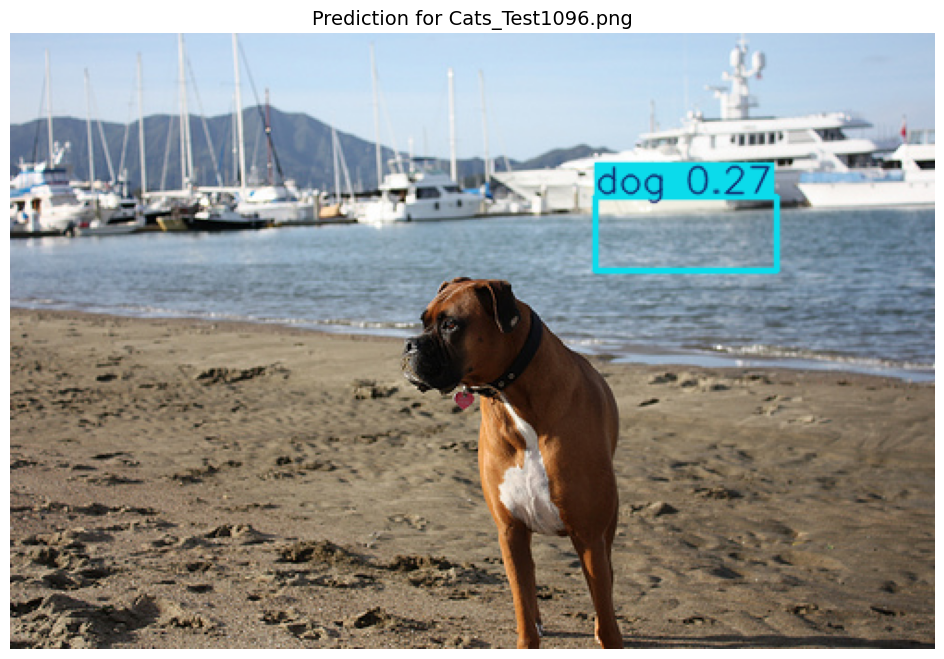

  Image: /kaggle/input/dog-and-cat-detection/images/Cats_Test1096.png
  Number of detected objects: 1
    - Detected: dog (ID: 1), Conf: 0.27, Box: [316.22, 88.45, 414.99, 128.23]

--- Processing Image 4/7: Cats_Test2860.png ---

image 1/1 /kaggle/input/dog-and-cat-detection/images/Cats_Test2860.png: 640x384 (no detections), 78.7ms
Speed: 2.4ms preprocess, 78.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


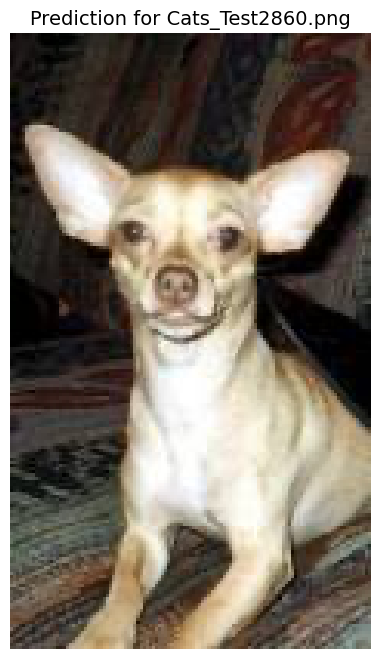

  Image: /kaggle/input/dog-and-cat-detection/images/Cats_Test2860.png
  Number of detected objects: 0
  No objects detected in this image.

--- Processing Image 5/7: Cats_Test104.png ---

image 1/1 /kaggle/input/dog-and-cat-detection/images/Cats_Test104.png: 448x640 2 cats, 14.0ms
Speed: 5.0ms preprocess, 14.0ms inference, 2.3ms postprocess per image at shape (1, 3, 448, 640)


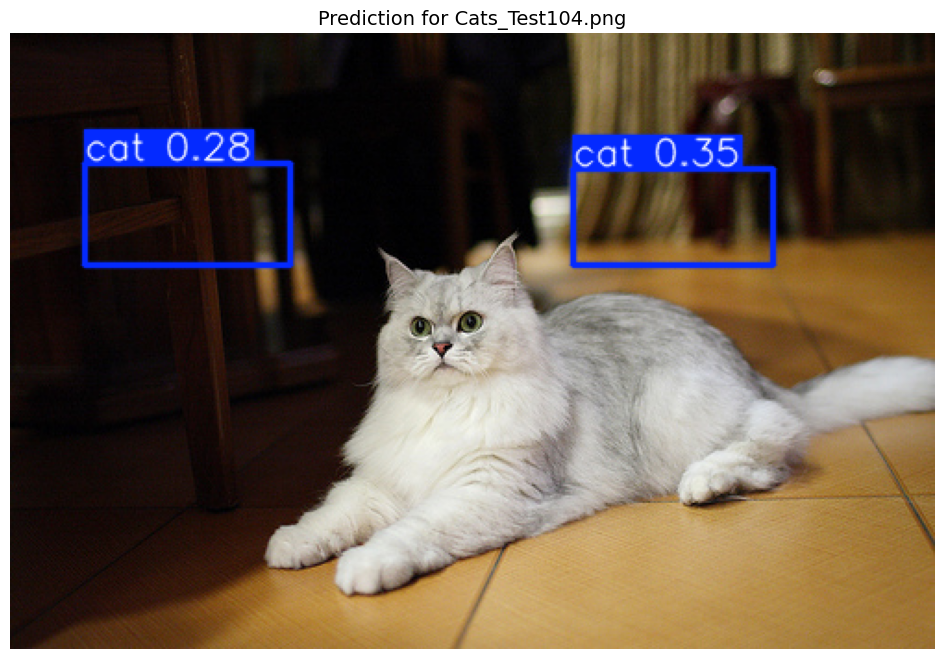

  Image: /kaggle/input/dog-and-cat-detection/images/Cats_Test104.png
  Number of detected objects: 2
    - Detected: cat (ID: 0), Conf: 0.35, Box: [304.12, 73.45, 412.58, 125.32]
    - Detected: cat (ID: 0), Conf: 0.28, Box: [40.39, 70.56, 151.22, 125.01]

--- Processing Image 6/7: Cats_Test1855.png ---

image 1/1 /kaggle/input/dog-and-cat-detection/images/Cats_Test1855.png: 544x640 2 dogs, 78.7ms
Speed: 3.6ms preprocess, 78.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)


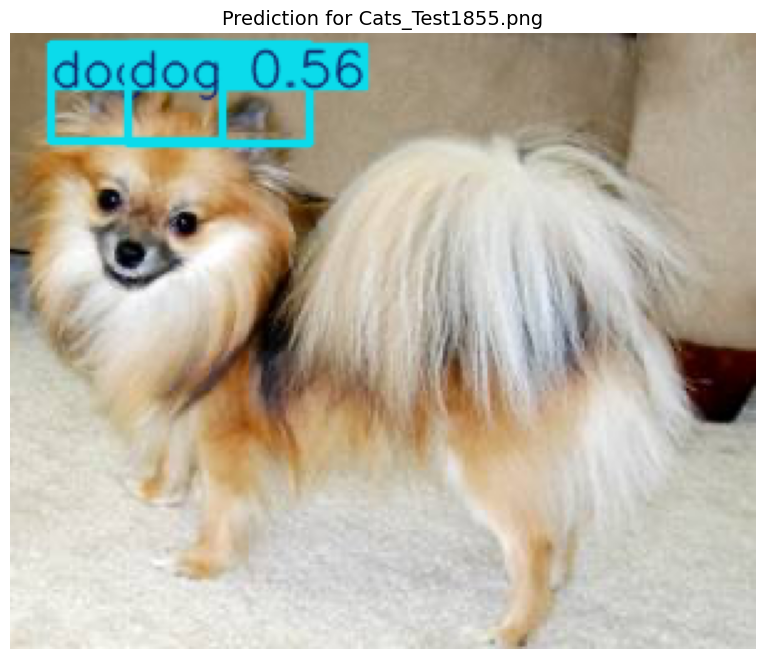

  Image: /kaggle/input/dog-and-cat-detection/images/Cats_Test1855.png
  Number of detected objects: 2
    - Detected: dog (ID: 1), Conf: 0.56, Box: [47.67, 4.69, 120.48, 44.71]
    - Detected: dog (ID: 1), Conf: 0.42, Box: [16.30, 4.99, 85.43, 43.63]

--- Processing Image 7/7: Cats_Test2254.png ---

image 1/1 /kaggle/input/dog-and-cat-detection/images/Cats_Test2254.png: 640x416 (no detections), 72.3ms
Speed: 2.6ms preprocess, 72.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


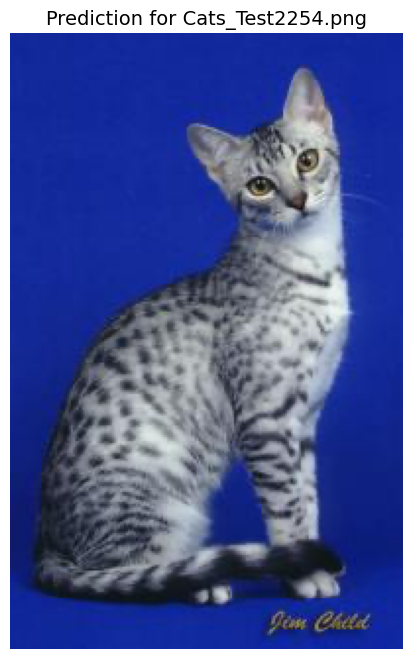

  Image: /kaggle/input/dog-and-cat-detection/images/Cats_Test2254.png
  Number of detected objects: 0
  No objects detected in this image.

--- Displaying Training Graphs (F1, Precision, etc.) ---
Displaying: F1 Curve


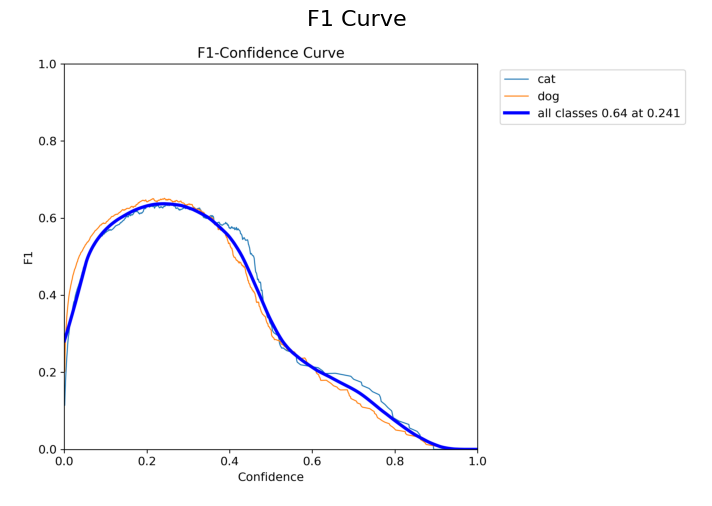

Displaying: Precision Curve


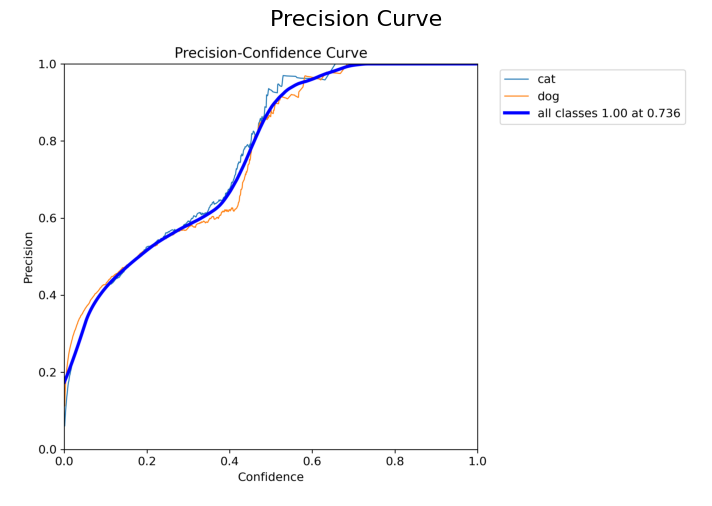

Displaying: Recall Curve


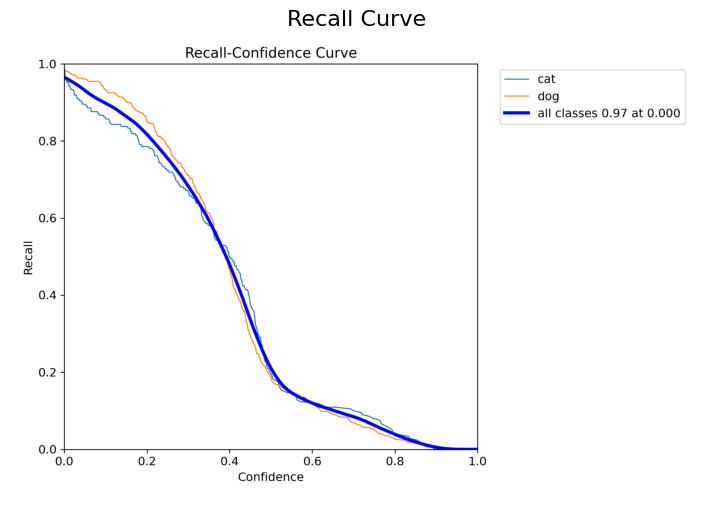

Displaying: Precision-Recall Curve


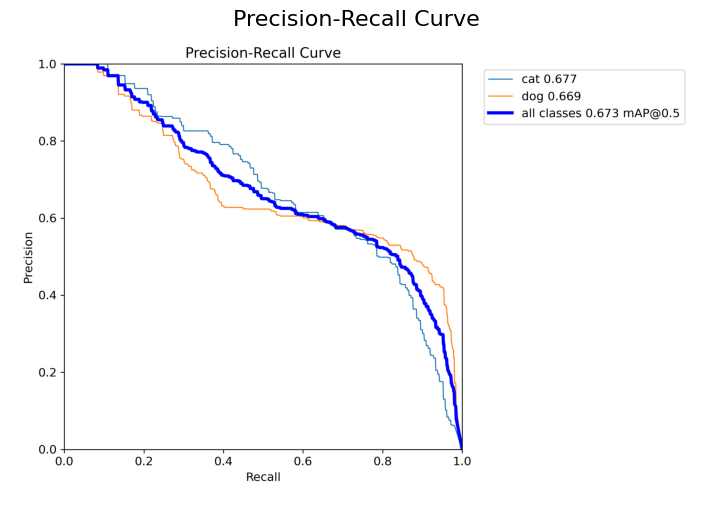

Displaying: Overall Results (Metrics over Epochs)


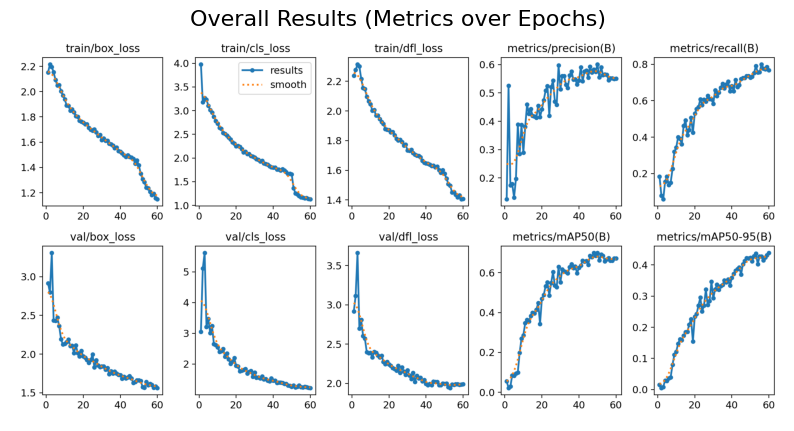

Displaying: Confusion Matrix


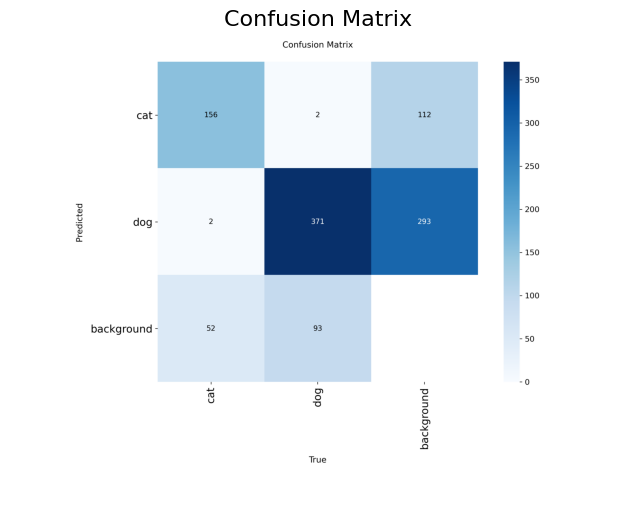

Displaying: Normalized Confusion Matrix


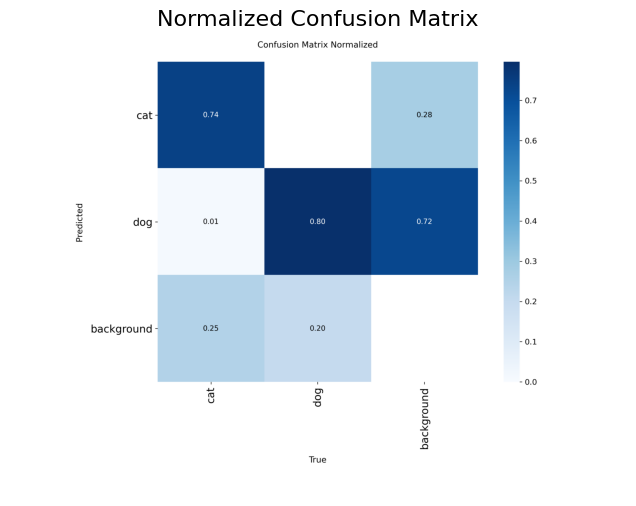

Displaying: Labels Distribution


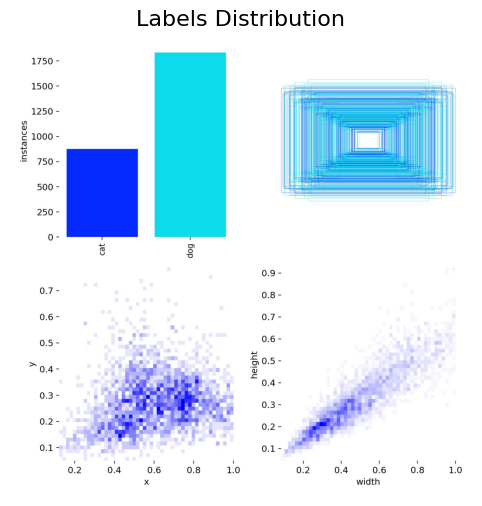

Displaying: Labels Correlogram


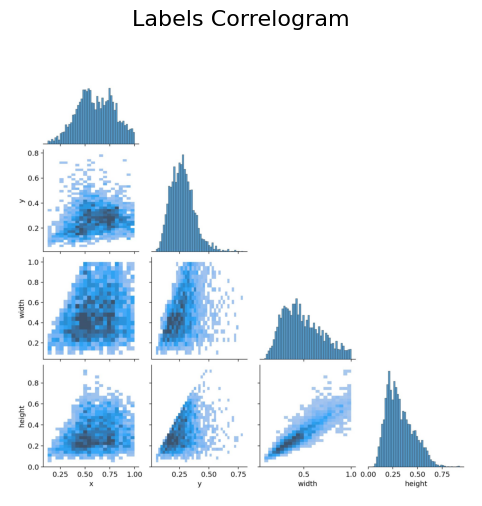


All requested images and graphs displayed.


In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image
from ultralytics import YOLO
import random

# --- Part 1: Model Loading ---

model_path = '/content/runs/detect/train4/weights/best.pt'

# Load the model
try:
    model = YOLO(model_path)
    print(f"Successfully loaded model from {model_path}")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Please ensure your training run completed and saved weights to the specified path.")
    exit()

print("\n--- Displaying 7 random images with predictions ---")

# --- Part 2: Dynamic Sample Image Selection and Prediction ---
dataset_root_mounted = '/kaggle/input/dog-and-cat-detection'
images_dir_for_inference = os.path.join(dataset_root_mounted, 'images')

# Check for nested directory structure for images
if not os.path.exists(images_dir_for_inference) and os.path.exists(os.path.join(dataset_root_mounted, 'dog-and-cat-detection', 'images')):
    images_dir_for_inference = os.path.join(dataset_root_mounted, 'dog-and-cat-detection', 'images')

if not os.path.exists(images_dir_for_inference):
    print(f"Error: Images directory for inference not found at {images_dir_for_inference}")
    print("Please manually inspect the mounted dataset structure in the Kaggle file explorer.")
else:
    all_image_files = [f for f in os.listdir(images_dir_for_inference) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if not all_image_files:
        print(f"Error: No image files found in {images_dir_for_inference}. Check if the directory contains images.")
    else:
        # Get 7 random image files (or fewer if less than 7 available)
        num_images_to_display = min(7, len(all_image_files))
        random_image_filenames = random.sample(all_image_files, num_images_to_display)

        for i, filename in enumerate(random_image_filenames):
            sample_image_path = os.path.join(images_dir_for_inference, filename)

            if os.path.exists(sample_image_path):
                print(f"\n--- Processing Image {i+1}/{num_images_to_display}: {filename} ---")
                results = model(sample_image_path) # Perform inference

                # Display the image with predictions
                for r in results:
                    im_array = r.plot()  # plot a BGR numpy array of predictions
                    im = Image.fromarray(im_array[..., ::-1])  # Convert BGR to RGB PIL Image

                    plt.figure(figsize=(12, 8)) # Adjust figure size for better viewing
                    plt.imshow(im)
                    plt.axis('off')
                    plt.title(f"Prediction for {os.path.basename(r.path)}", fontsize=14)
                    plt.show()

                    # Print detection details
                    print(f"  Image: {r.path}")
                    print(f"  Number of detected objects: {len(r.boxes)}")
                    if len(r.boxes) > 0:
                        for box in r.boxes:
                            xyxy = box.xyxy[0].tolist()
                            conf = box.conf[0].item()
                            cls = int(box.cls[0].item())
                            class_name = model.names[cls]
                            print(f"    - Detected: {class_name} (ID: {cls}), Conf: {conf:.2f}, Box: [{xyxy[0]:.2f}, {xyxy[1]:.2f}, {xyxy[2]:.2f}, {xyxy[3]:.2f}]")
                    else:
                        print("  No objects detected in this image.")

            else:
                print(f"Critical Error: Sample image {sample_image_path} somehow disappeared during iteration. Skipping.")


print("\n--- Displaying Training Graphs (F1, Precision, etc.) ---")

# --- Part 3: Displaying Training Graphs ---
# These are automatically saved by Ultralytics during training in your run directory.
training_results_dir = '/content/runs/detect/train4/'

graph_files = {
    "F1 Curve": "F1_curve.png",
    "Precision Curve": "P_curve.png",
    "Recall Curve": "R_curve.png",
    "Precision-Recall Curve": "PR_curve.png",
    "Overall Results (Metrics over Epochs)": "results.png",
    "Confusion Matrix": "confusion_matrix.png",
    "Normalized Confusion Matrix": "confusion_matrix_normalized.png",
    "Labels Distribution": "labels.jpg",
    "Labels Correlogram": "labels_correlogram.jpg",
}

for title, filename in graph_files.items():
    graph_path = os.path.join(training_results_dir, filename)
    if os.path.exists(graph_path):
        print(f"Displaying: {title}")
        plt.figure(figsize=(10, 6))
        img = Image.open(graph_path)
        plt.imshow(img)
        plt.title(title, fontsize=16)
        plt.axis('off')
        plt.show()
    else:
        print(f"Warning: {title} not found at {graph_path}. This plot might not have been generated by your training run.")

print("\nAll requested images and graphs displayed.")